<a href="https://colab.research.google.com/github/mendyhsu/Capstone2/blob/main/TF2_CNN_FashionProducts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN classifier on Fashion Products (color images)

In [4]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.6.0


In [5]:
# additional imports
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D #GlobalMaxPooling2D
from tensorflow.keras.models import Model

## Load Files

In [6]:
# Access files from your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!ls 'gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/archive (1).zip'

'gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/archive (1).zip'


In [8]:
from zipfile import ZipFile

with ZipFile('gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/archive (1).zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [9]:
!ls 

gdrive	images	my_model.h5  myntradataset  sample_data  styles.csv


In [10]:
## List of image file paths
img_files = glob.glob('myntradataset/images/*.jpg')

#img_id = [int(re.findall(r'\d+', img)[0]) for img in img_files]
img_id = [(re.findall(r'\d+', img)[0]) for img in img_files]

print('Total number of images:', len(set(img_id)))


Total number of images: 44441


myntradataset/images/54968.jpg
(80, 60, 3)


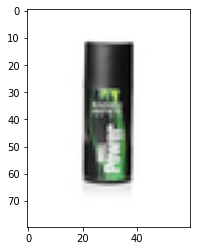

In [11]:
## View the image
image_path = 'myntradataset/images/54968.jpg'#img_files[20]
print(image_path)
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
_ = plt.imshow(input_arr/255)
img_size = input_arr.shape
print(img_size)

In [12]:
## Check styles.csv
!head 'myntradataset/styles.csv'

id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt
30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt
26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt
29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks


In [13]:
## Load styles sheets
styles = pd.read_csv('myntradataset/styles.csv', header=None, names=range(11))
styles.drop(columns=10, inplace=True)
styles.columns = styles.iloc[0]
styles = styles.iloc[1:].reset_index(drop=True)
#styles.id = pd.to_numeric(styles['id'])
#styles.year = pd.to_numeric(styles['year'])
styles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44446 non-null  object
 1   gender              44446 non-null  object
 2   masterCategory      44446 non-null  object
 3   subCategory         44446 non-null  object
 4   articleType         44446 non-null  object
 5   baseColour          44431 non-null  object
 6   season              44425 non-null  object
 7   year                44445 non-null  object
 8   usage               44129 non-null  object
 9   productDisplayName  44439 non-null  object
dtypes: object(10)
memory usage: 3.4+ MB


In [14]:
print('Total number of id (styles):', len(set(styles.id)))
print('Total number of images:', len(set(img_id)))

## Keep the overlaped images==id
no_img = set(styles.id).difference(img_id)
styles = styles[~styles.id.isin(no_img)]
styles.shape

Total number of id (styles): 44446
Total number of images: 44441


(44441, 10)

In [15]:
styles.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch


## Check/refine the Categorical Features

In [16]:
## See Categorical counts
styles.masterCategory.value_counts()

Apparel           21395
Accessories       11289
Footwear           9222
Personal Care      2404
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64

In [52]:
cat_sort = styles[['masterCategory','subCategory']].value_counts().to_frame().reset_index()
display(cat_sort.head(60))

# cat_repalce = cat_sort[(cat_sort[0]>=105)]['subCategory'].to_list()
# #len(set(cat_repalce))
# set(cat_repalce)

,masterCategory,subCategory,0
0,Apparel,Topwear,15401
1,Footwear,Shoes,7344
2,Accessories,Bags,3055
3,Apparel,Bottomwear,2693
4,Accessories,Watches,2542
5,Apparel,Innerwear,1808
6,Accessories,Jewellery,1080
7,Accessories,Eyewear,1073
8,Personal Care,Fragrance,1012
9,Footwear,Sandal,963


In [54]:
## Set a new Categorical features `Class`

# 1) Keep the masterCategory
styles['Class'] = styles['masterCategory'] 

# 2) if `subCategory` has counts >= 90, keep its category label
cat_sort = styles[['masterCategory','subCategory']].value_counts().to_frame().reset_index()
display(cat_sort.head(60))

cat_repalce = cat_sort[(cat_sort[0]>105)]['subCategory'].to_list()
row_sel = styles['subCategory'].isin(cat_repalce)
styles.loc[row_sel,'Class'] = styles.loc[row_sel,'subCategory']


,masterCategory,subCategory,0
0,Apparel,Topwear,15401
1,Footwear,Shoes,7344
2,Accessories,Bags,3055
3,Apparel,Bottomwear,2693
4,Accessories,Watches,2542
5,Apparel,Innerwear,1808
6,Accessories,Jewellery,1080
7,Accessories,Eyewear,1073
8,Personal Care,Fragrance,1012
9,Footwear,Sandal,963


In [58]:

# 2) if `subCategory` has counts >= 90, keep its category label
cat_sort = styles[['Class','articleType']].value_counts().to_frame().reset_index()
display(cat_sort.head(60))

cat_repalce = cat_sort[(cat_sort[0]>1000)]['articleType'].to_list()
row_sel = styles['articleType'].isin(cat_repalce)
styles.loc[row_sel,'Class'] = styles.loc[row_sel,'articleType']

print(len(set(styles['Class'])))
set(styles['Class'])

,Class,articleType,0
0,Tshirts,Tshirts,7069
1,Shirts,Shirts,3215
2,Casual Shoes,Casual Shoes,2846
3,Watches,Watches,2542
4,Sports Shoes,Sports Shoes,2036
5,Kurtas,Kurtas,1844
6,Tops,Tops,1762
7,Handbags,Handbags,1759
8,Heels,Heels,1323
9,Sunglasses,Sunglasses,1073


38


{'Accessories',
 'Apparel Set',
 'Bags',
 'Belts',
 'Bottomwear',
 'Casual Shoes',
 'Cufflinks',
 'Dress',
 'Flip Flops',
 'Fragrance',
 'Free Items',
 'Handbags',
 'Headwear',
 'Heels',
 'Home',
 'Innerwear',
 'Jewellery',
 'Kurtas',
 'Lips',
 'Loungewear and Nightwear',
 'Makeup',
 'Nails',
 'Personal Care',
 'Sandal',
 'Saree',
 'Scarves',
 'Shirts',
 'Shoes',
 'Socks',
 'Sporting Goods',
 'Sports Shoes',
 'Sunglasses',
 'Ties',
 'Tops',
 'Topwear',
 'Tshirts',
 'Wallets',
 'Watches'}

In [61]:
# Reassign `Class` to some of the `Free Items` 
# (i.e., these images are not classified properly.)
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Watch'),'Class']='Watches'
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Tie'),'Class']='Ties'
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Wallet'),'Class']='Wallets'
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Sunglasses'),'Class']='Sunglasses'
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Handbag'),'Class']='Handbags'
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Saree'),'Class']='Saree'

styles['image'] = styles.apply(lambda row: str(row['id']) + ".jpg", axis=1)
styles.head()

# The rest of free items without Class name. They will be used for prediction.
styles_unkonw = styles[styles['Class'].str.contains('Free')].copy()
print(styles_unkonw.shape)

# The items with well-defined Class. They will be used as train-validation.
styles_know = styles[~styles['Class'].str.contains('Free')].copy()
print(styles_know.shape)

(20, 12)
(44421, 12)


In [62]:
styles_know['Class'].value_counts()

Tshirts                     7069
Shirts                      3215
Casual Shoes                2846
Bottomwear                  2693
Watches                     2588
Sports Shoes                2036
Kurtas                      1844
Innerwear                   1808
Tops                        1762
Handbags                    1761
Topwear                     1512
Heels                       1323
Bags                        1298
Shoes                       1139
Sunglasses                  1081
Jewellery                   1080
Fragrance                   1012
Sandal                       963
Wallets                      935
Flip Flops                   915
Belts                        810
Socks                        698
Lips                         527
Dress                        478
Loungewear and Nightwear     470
Saree                        444
Accessories                  332
Nails                        329
Makeup                       307
Headwear                     293
Ties      

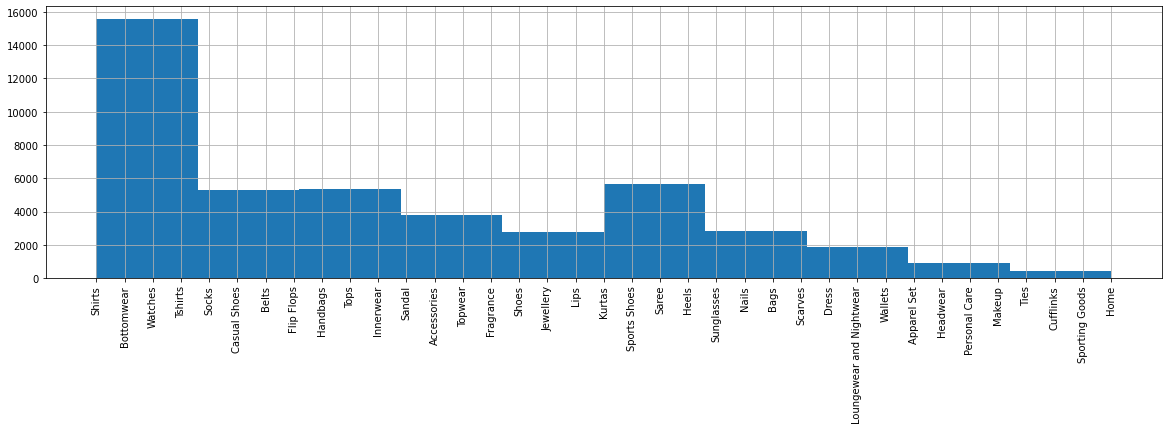

(37,)

In [63]:
styles_know.Class.hist(figsize=(20,5))
plt.xticks(rotation=90)
plt.show()

styles_know.Class.value_counts().shape

In [ ]:
## LabelEncoder
# le = LabelEncoder()
# styles_know['Class_ind'] = le.fit_transform(styles_know['Class'])


## Train validation splits

In [64]:
from keras_preprocessing.image import ImageDataGenerator

DATASET_PATH = 'myntradataset/images/'
batch_size = 32

image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

## Train, validation splits
train_generator = image_generator.flow_from_dataframe(
    dataframe=styles_know,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=img_size[:2],
    batch_size=batch_size,
    subset="training"
)

valid_generator = image_generator.flow_from_dataframe(
    dataframe=styles_know,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=img_size[:2],
    batch_size=batch_size,
    shuffle = False,
    subset="validation"
)


Found 35537 validated image filenames belonging to 37 classes.
Found 8884 validated image filenames belonging to 37 classes.
37


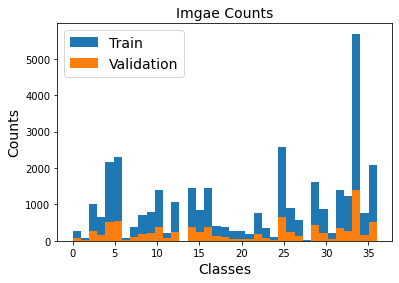

In [114]:
# Number of classes
classes = len(train_generator.class_indices) #len(set(styles_know['Class']))
print("number of classes:", classes)

# Number of images in each class
_ = plt.hist(train_generator.classes, bins=classes, label='Train')
_ = plt.hist(valid_generator.classes, bins=classes, label='Validation')
plt.legend(fontsize=14)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Imgae Counts', fontsize=14)
plt.show()

## Build the CNN classification model

In [67]:
## Build the model using the Keras API
model = tf.keras.models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=img_size))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(classes, activation='softmax'))

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
#tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 11, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 22528)             0         
_________________________________________________________________
dropout (Dropout)            (None, 22528)             0

In [68]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

## Compile and fit
# Note: make sure to use GPU/TPU on Google Colab.
r=model.fit(x=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
            epochs=5)

Epoch 1/5
1110/1110 [==============================] - 499s 449ms/step - loss: 0.9703 - accuracy: 0.7106 - val_loss: 0.6283 - val_accuracy: 0.8084
Epoch 2/5
1110/1110 [==============================] - 482s 434ms/step - loss: 0.5386 - accuracy: 0.8287 - val_loss: 0.5904 - val_accuracy: 0.8037
Epoch 3/5
1110/1110 [==============================] - 478s 431ms/step - loss: 0.4650 - accuracy: 0.8527 - val_loss: 0.5411 - val_accuracy: 0.8301
Epoch 4/5
1110/1110 [==============================] - 480s 432ms/step - loss: 0.4331 - accuracy: 0.8618 - val_loss: 0.5429 - val_accuracy: 0.8401
Epoch 5/5
1110/1110 [==============================] - 476s 429ms/step - loss: 0.4086 - accuracy: 0.8719 - val_loss: 0.6024 - val_accuracy: 0.8378


In [ ]:
# Build the model using the functional API
# i = Input(shape=x_train[0].shape)
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
# x = Flatten()(x)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(classes, activation='softmax')(x)

# model = Model(i, x)

## Compile and fit
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

In [107]:
## Save model
#model.save('my_model.h5')

# Load model
#model = tf.keras.models.load_model('my_model.h5')

# Check its architecture
#model.summary()

## Model Evaluation

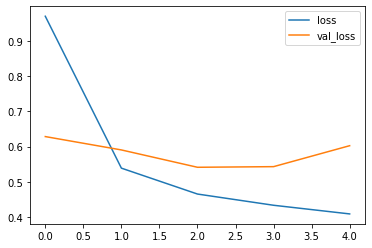

In [70]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [71]:
# The accuracy for validation set
model.evaluate(valid_generator, batch_size=1)


278/278 [==============================] - 29s 105ms/step - loss: 0.6016 - accuracy: 0.8379


[0.6015692949295044, 0.8379108309745789]

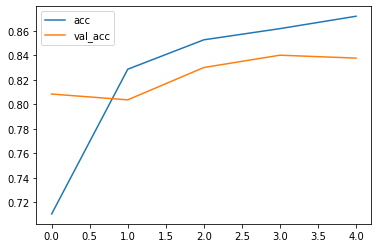

In [72]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [73]:
from sklearn.metrics import confusion_matrix, classification_report#, plot_confusion_matrix
import numpy as np
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  Code from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  #print(cm)

  plt.figure(figsize=(20,20))
  ax = plt.gca()
  sns.heatmap(cm, annot=True, fmt="d", linewidths=.01, cmap=cmap, #"YlGnBu", 
            xticklabels=classes,
            yticklabels=classes,
            ax=ax)
  
  ax.set_title(title)
  ax.set_ylabel('True label')
  ax.set_xlabel('Predicted label')
  plt.tight_layout()
  
  # cax = divider.append_axes("right", size="5%", pad=0.05)
  # plt.colorbar(im, cax=cax)
  plt.show()

In [74]:
labels = {v: k for k, v in train_generator.class_indices.items()}

In [75]:
p_test = model.predict(valid_generator).argmax(axis=1)
y_test = list(valid_generator.classes)
len(y_test)

8884

Confusion matrix, without normalization


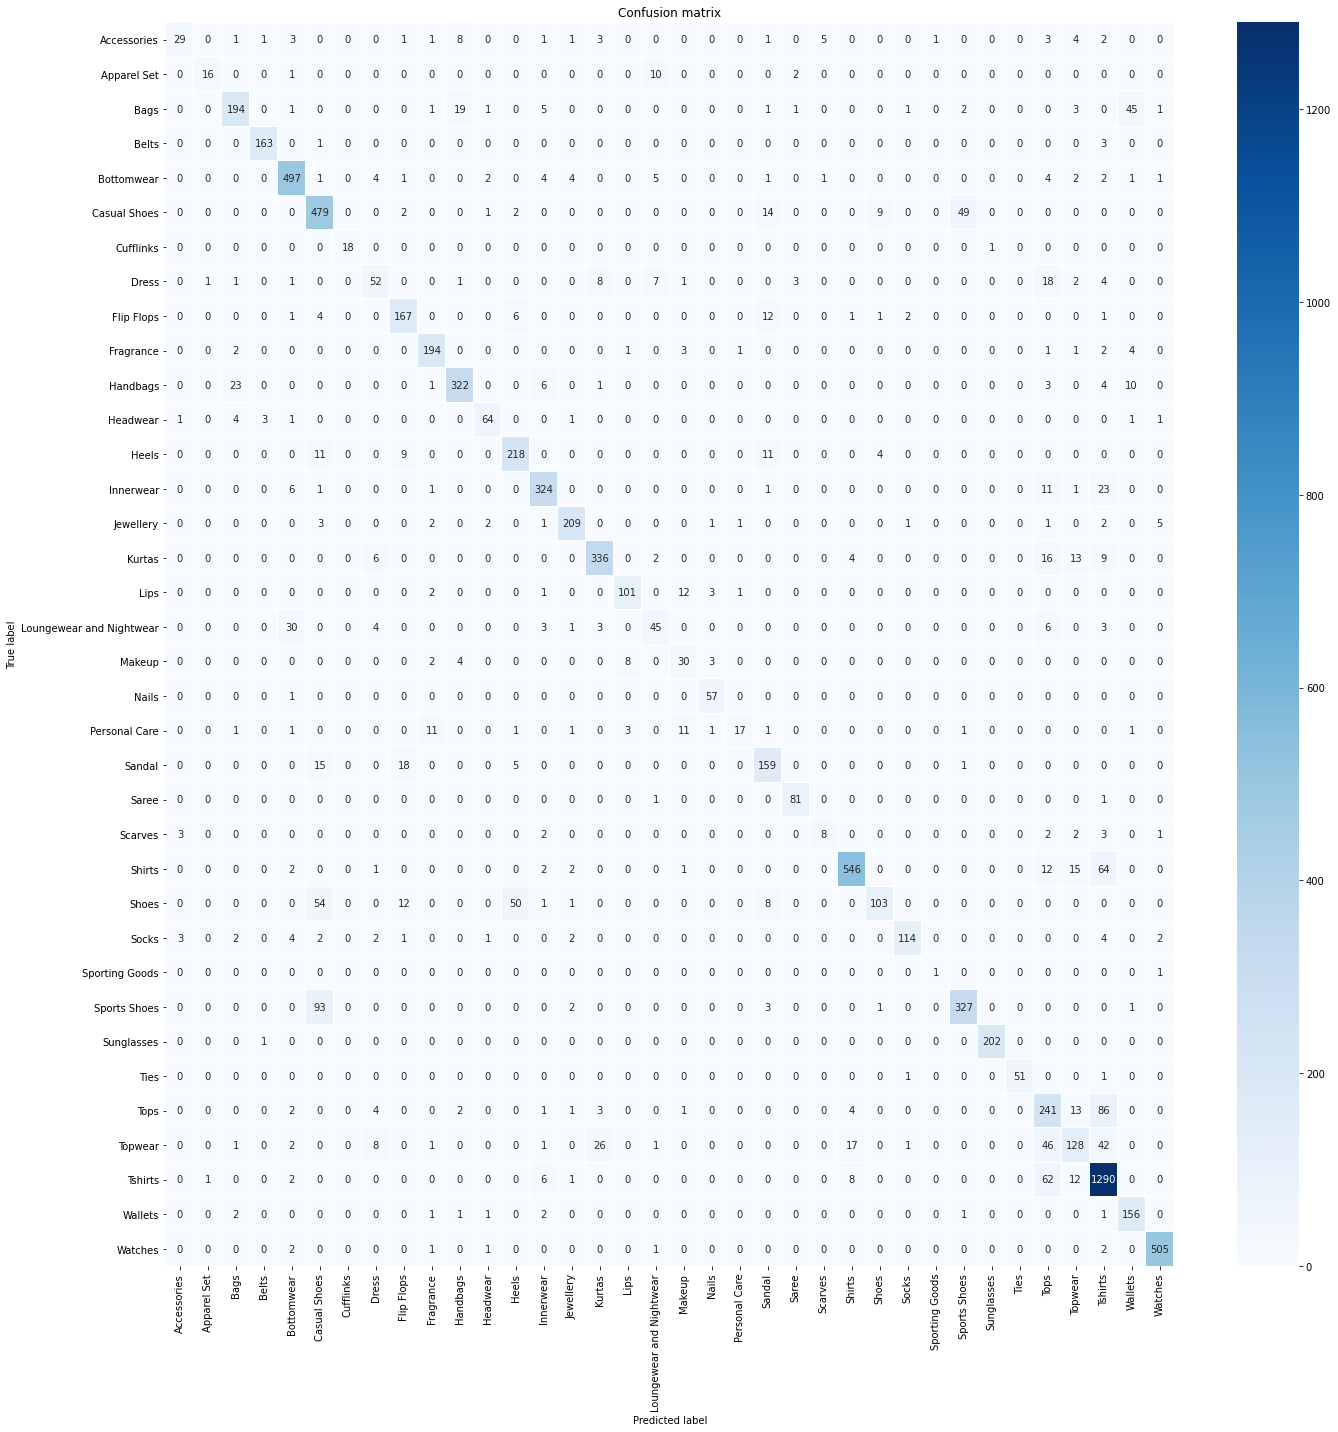

              precision    recall  f1-score   support

           0       0.81      0.45      0.57        65
           1       0.89      0.55      0.68        29
           2       0.84      0.71      0.77       275
           3       0.97      0.98      0.97       167
           4       0.89      0.94      0.91       530
           5       0.72      0.86      0.79       556
           6       1.00      0.95      0.97        19
           7       0.64      0.53      0.58        99
           8       0.79      0.86      0.82       195
           9       0.89      0.93      0.91       209
          10       0.90      0.87      0.89       370
          11       0.88      0.84      0.86        76
          12       0.77      0.86      0.81       253
          14       0.90      0.88      0.89       368
          15       0.92      0.92      0.92       228
          16       0.88      0.87      0.88       386
          17       0.89      0.84      0.87       120
          18       0.62    

In [76]:
# Plot confusion matrix

#p_test = model.predict(valid_generator).argmax(axis=1)
#cm = tf.math.confusion_matrix(y_test, p_test).numpy() #confusion_matrix(y_test, p_test)
class_name = [labels[i] for i in list(set(valid_generator.classes))]
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, class_name)
print(classification_report(y_test, p_test))


In [77]:
# label mapping
print('Number of misclassified images:',np.sum(p_test != y_test))

Number of misclassified images: 1440


In [78]:
# Collect the test images: x_test
x, _ = zip(*(valid_generator[i] for i in range(len(valid_generator))))
x_test = np.vstack(x)


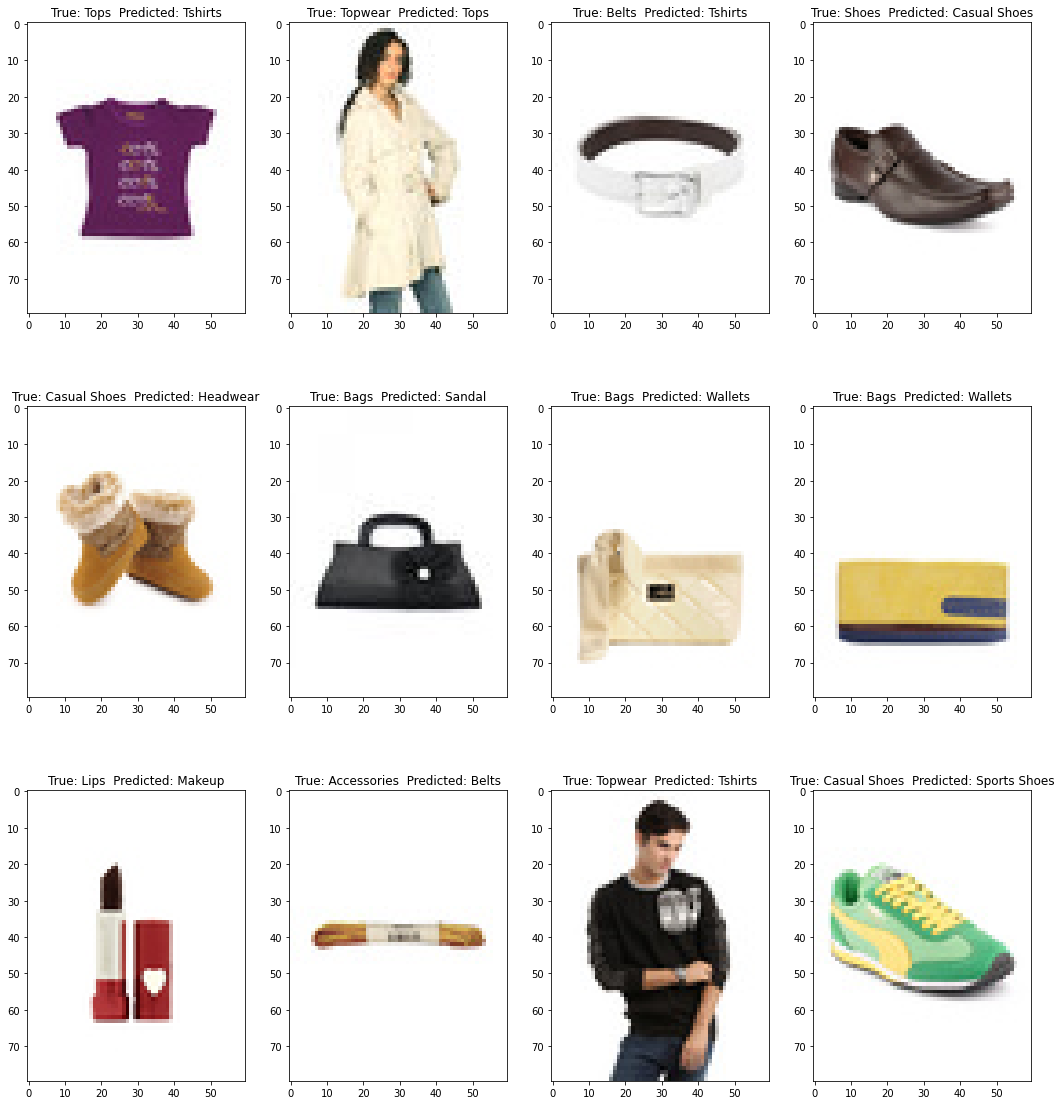

In [106]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]

fig, axes = plt.subplots(3, 4, figsize=(18,20))
for i, img in enumerate(np.random.choice(misclassified_idx, 12)):
  ax = axes.flat[i]
  ax.imshow(x_test[img], cmap='gray')
  ax.set_title("True: %s  Predicted: %s" % 
            (labels[y_test[img]], labels[p_test[img]]));
plt.show()

## Prediect the Classes for Unknow Images

We are going to predict the classes for images lebeled as `Free Items`, listed in the DataFrame `styles_unkonw`. These images are new (not in train and validation sets). As we shell see, for most of the cases the predicted labels match the images.

In [118]:
styles_unkonw

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Class,image
2663,54970,Women,Free Items,Free Gifts,Free Gifts,Pink,Spring,2017,Casual,Rasasi Women Body Lotion,Free Items,54970.jpg
2871,15349,Men,Free Items,Free Gifts,Free Gifts,Blue,Winter,2012,Sports,Nike Men Blue Team India Cricket Jersey,Free Items,15349.jpg
4474,18434,Women,Free Items,Free Gifts,Laptop Bag,Purple,Summer,2015,Casual,Vital Gear Women Purple Laptop Bag,Free Items,18434.jpg
6816,43285,Women,Free Items,Free Gifts,Backpacks,Black,Summer,2016,Casual,Murcia Women Black Backpack,Free Items,43285.jpg
12454,45301,Men,Free Items,Free Gifts,Free Gifts,Black,Summer,2012,Formal,Van Heusen Men Black & Brown Reversible Belt,Free Items,45301.jpg
13747,51135,Men,Free Items,Free Gifts,Free Gifts,Black,Summer,2012,Casual,Park Avenue Men Black Socks,Free Items,51135.jpg
14771,57600,Women,Free Items,Free Gifts,Free Gifts,Purple,Spring,2017,Casual,Lotus Herbals Moistpetals Royal Plum Lipstick 116,Free Items,57600.jpg
16452,57457,Women,Free Items,Free Gifts,Free Gifts,Mustard,Summer,2015,Casual,Pitaraa Women Mustard Clutch,Free Items,57457.jpg
23778,25140,Women,Free Items,Free Gifts,Clutches,Metallic,Summer,2016,Party,Lino Perros Gunmetal-Toned Clutch,Free Items,25140.jpg
26179,23482,Men,Free Items,Free Gifts,Scarves,Black,Summer,2012,Casual,Arrow Men Black & White Scarf,Free Items,23482.jpg


In [115]:
new_generator = image_generator.flow_from_dataframe(
    dataframe=styles_unkonw,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=img_size[:2],
    batch_size=1,
    shuffle = False
    )

Found 20 validated image filenames belonging to 1 classes.


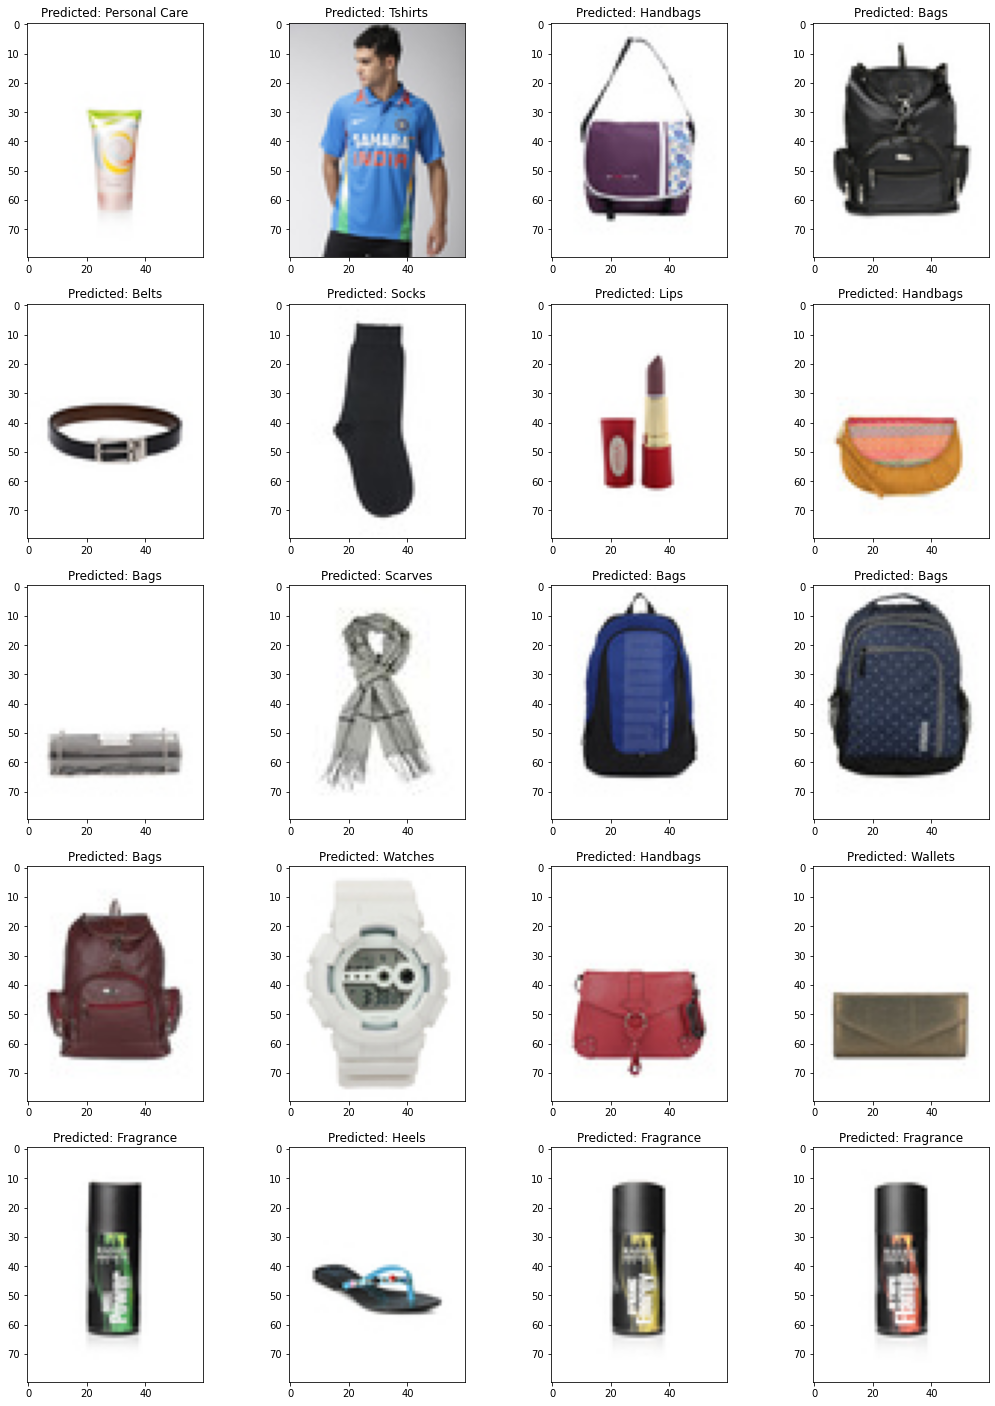

In [117]:
# Predicted labels
p_new = model.predict(new_generator).argmax(axis=1)

# Show some new examples
fig, axes = plt.subplots(5, 4, figsize=(18,25))

for i in range(len(new_generator)):
  # New images
  x_new = new_generator[i][0][0]
  
  ax = axes.flat[i]
  ax.imshow(x_new)
  ax.set_title("Predicted as: %s" % (labels[p_new[i]]))

plt.show()